In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

# Scikit-learn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline # Use sklearn Pipeline for non-SMOTE pipelines
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, accuracy_score, precision_recall_curve

# Imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline # Use imblearn pipeline for SMOTE compatibility

# Gradient Boosting
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Model Interpretation
import shap

# Settings
warnings.filterwarnings('ignore')
shap.initjs() # Initialize SHAP JS for notebook plots

print("Libraries imported successfully.")

Libraries imported successfully.


In [35]:
# Load the dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:\n", df.head())
print("\nColumn Info:\n")
df.info()
print("\nDescriptive Statistics (Numerical):\n", df.describe())

Dataset Shape: (7043, 21)

First 5 Rows:
    customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport Stream

In [36]:
print("\nMissing Values (%):\n", (df.isnull().sum() / len(df)) * 100)
# Note: 'TotalCharges' might appear non-missing but contain spaces. Check data types.
# Convert 'TotalCharges' to numeric, coercing errors (spaces become NaN)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print("\nMissing Values after TotalCharges conversion (%):\n", (df.isnull().sum() / len(df)) * 100)


Missing Values (%):
 customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

Missing Values after TotalCharges conversion (%):
 customerID          0.000000
gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
tenure              0.000000
PhoneService        0.000000
MultipleLines       0.000000
InternetService     0.000000
OnlineSecurity      0.000000
OnlineBackup        0.000000
DeviceProtection    0.000000
TechSupport         0.000000
StreamingTV         0.000000
S

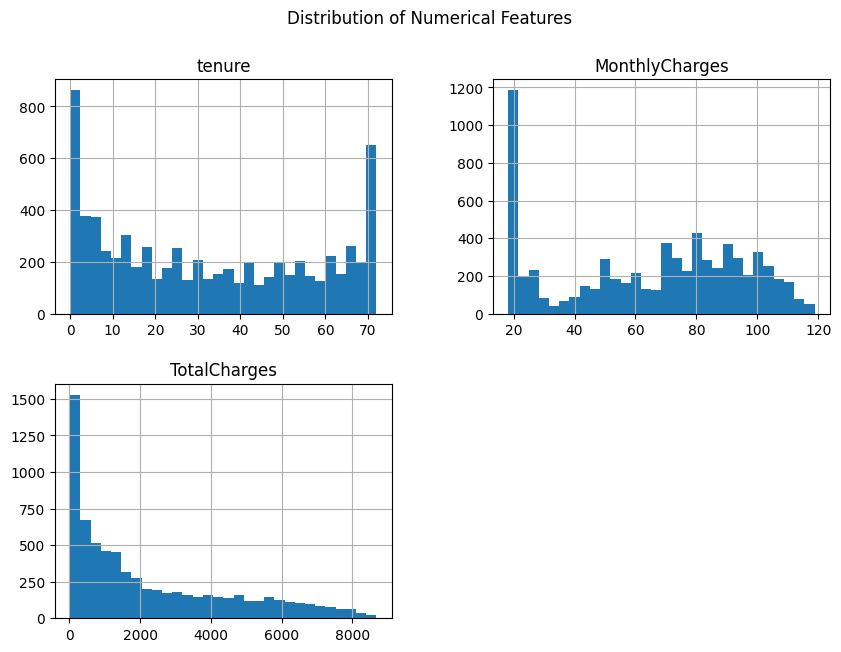

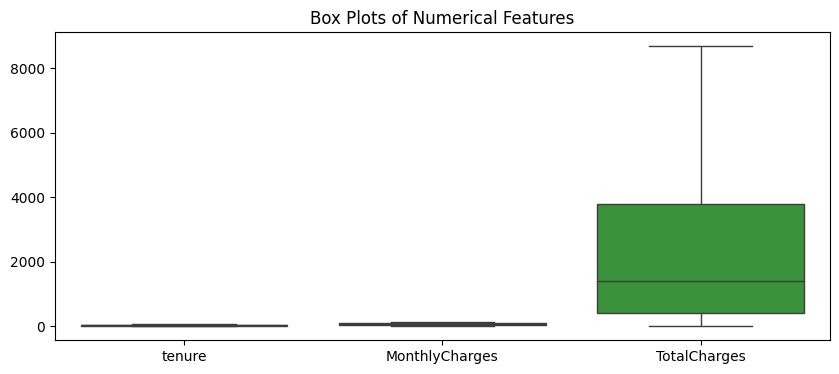

In [37]:
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numerical_features].hist(bins=30, figsize=(10, 7))
plt.suptitle("Distribution of Numerical Features")
plt.show()

plt.figure(figsize=(10, 4))
sns.boxplot(data=df[numerical_features])
plt.title("Box Plots of Numerical Features")
plt.show()

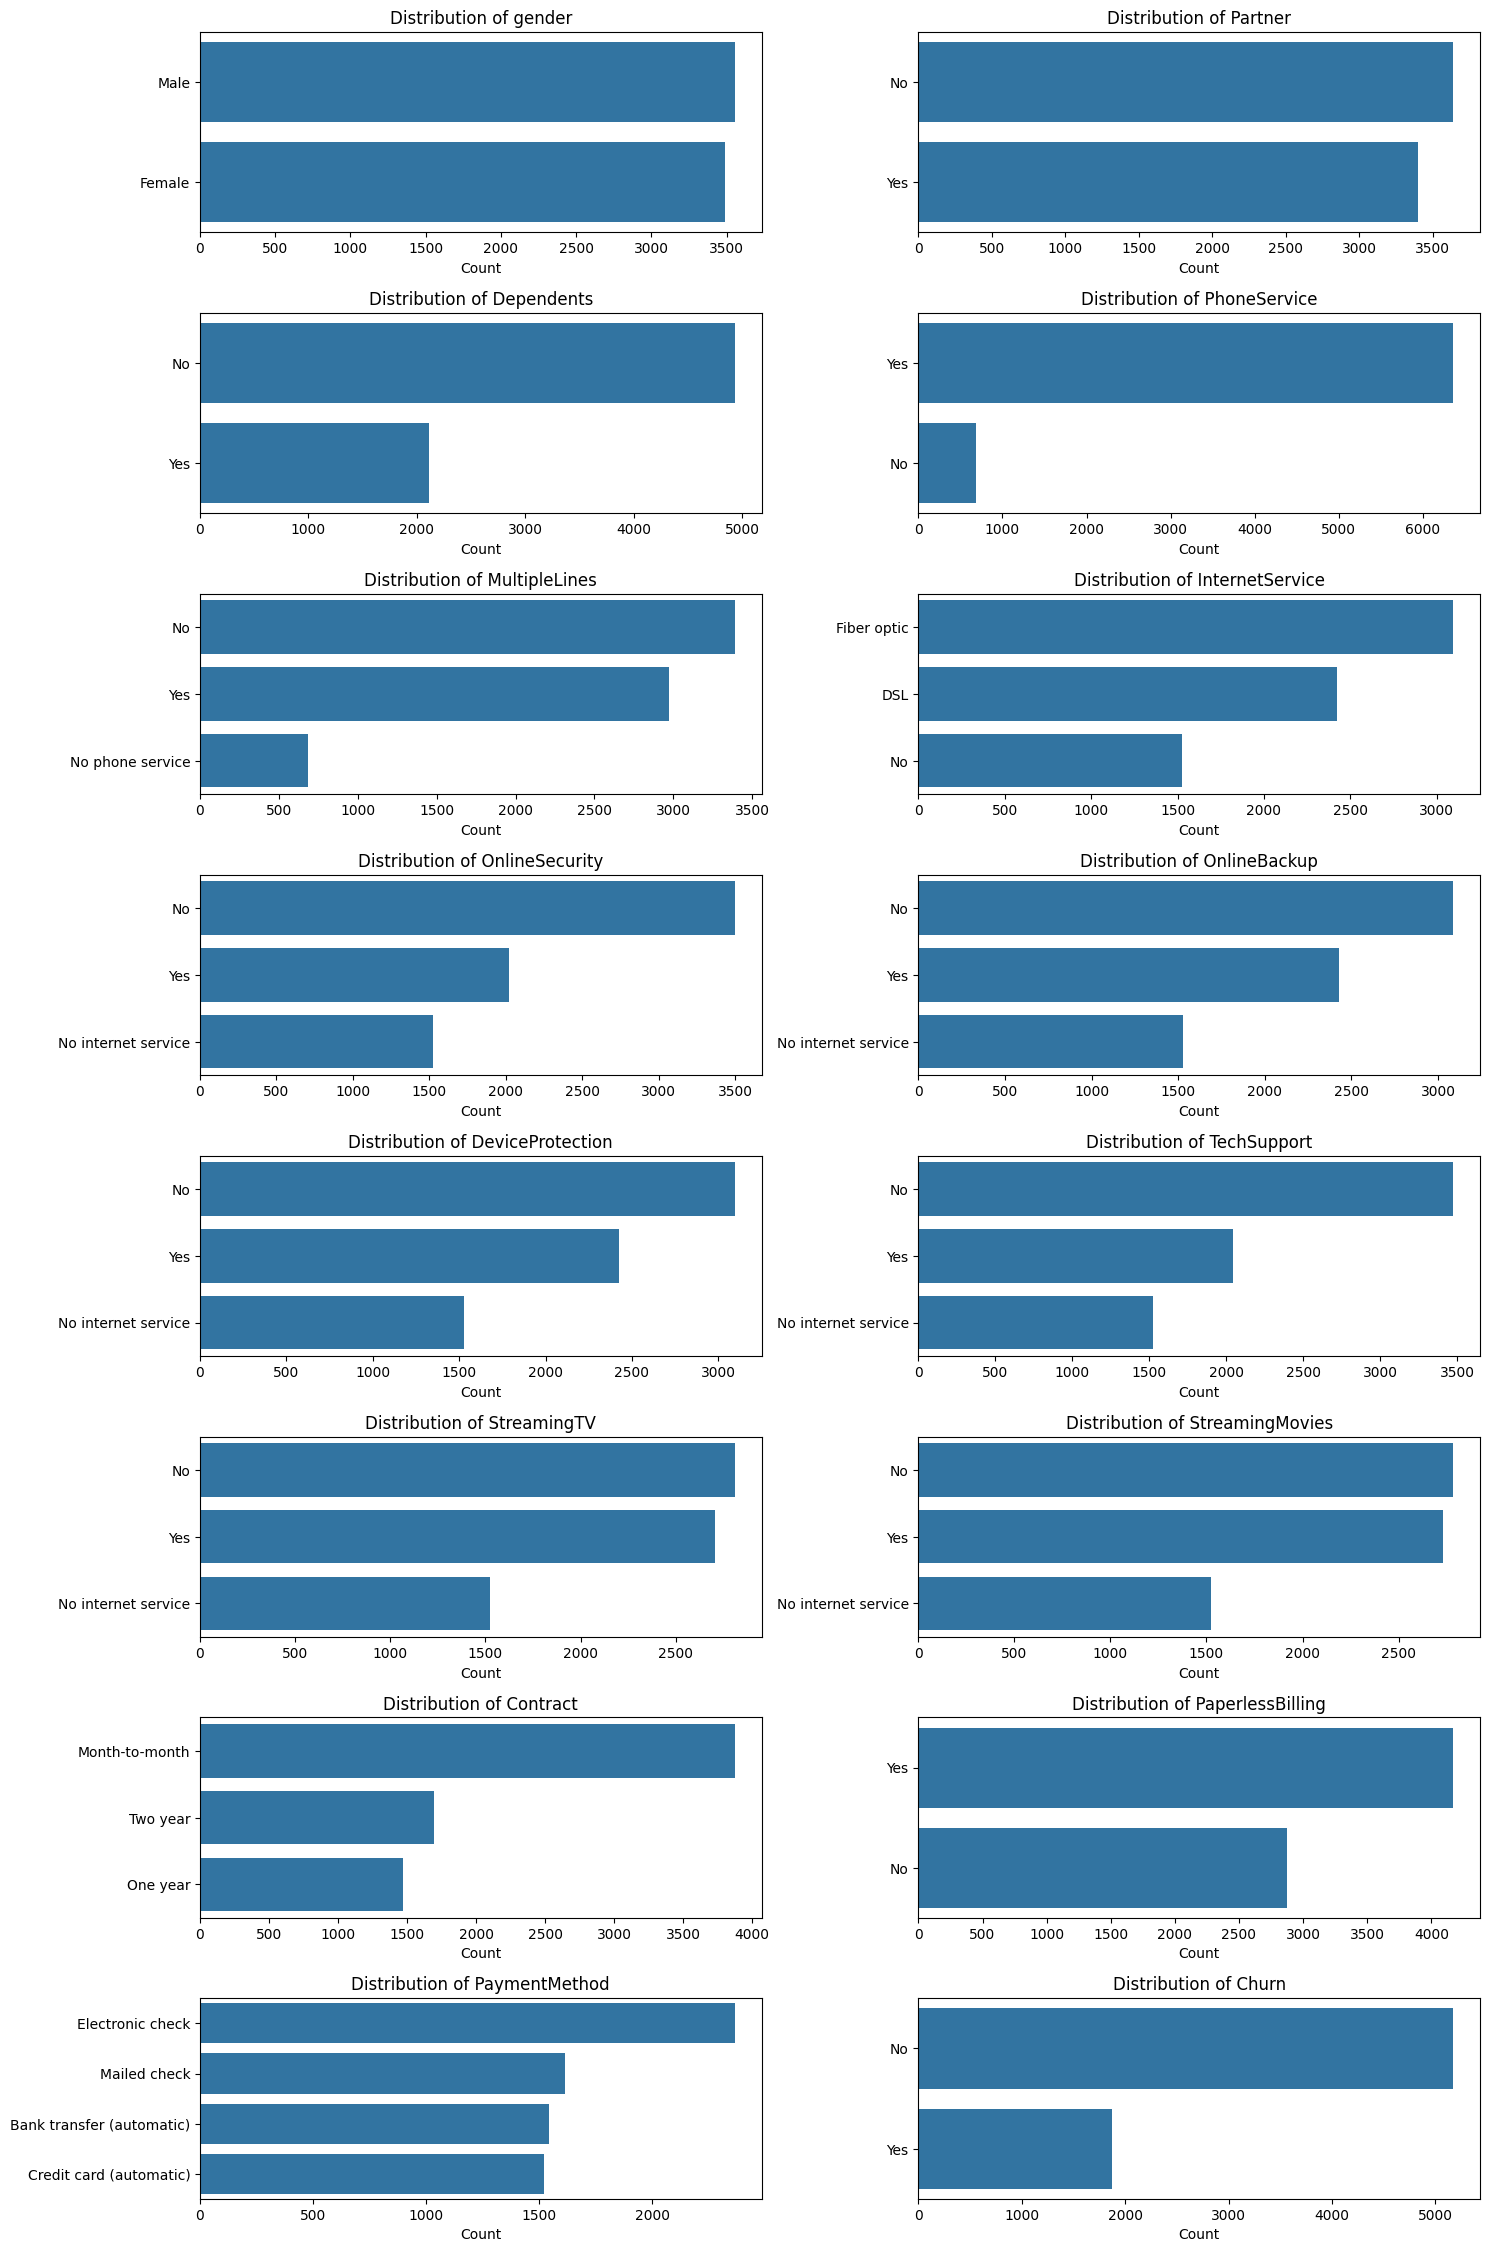

In [38]:
categorical_features = df.select_dtypes(include='object').columns.drop('customerID') # Exclude ID
plt.figure(figsize=(15, 25)) # Adjust figsize as needed
for i, col in enumerate(categorical_features):
    plt.subplot(len(categorical_features)//2 + 1, 2, i+1)
    sns.countplot(data=df, y=col, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Count')
    plt.ylabel('')
plt.tight_layout()
plt.show()

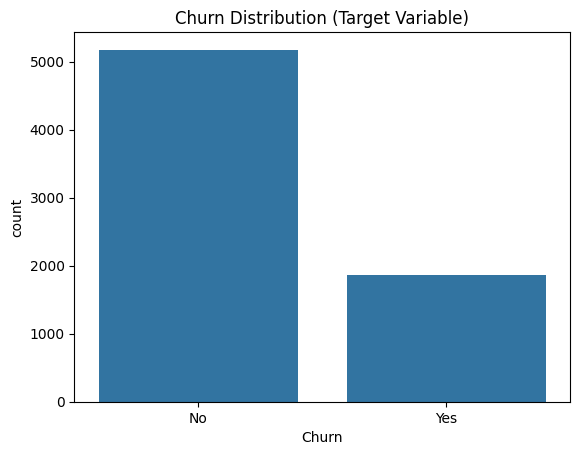


Churn Value Counts:
 Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


In [39]:
sns.countplot(data=df, x='Churn')
plt.title('Churn Distribution (Target Variable)')
plt.show()
print("\nChurn Value Counts:\n", df['Churn'].value_counts(normalize=True))
# Note: Potential class imbalance exists.

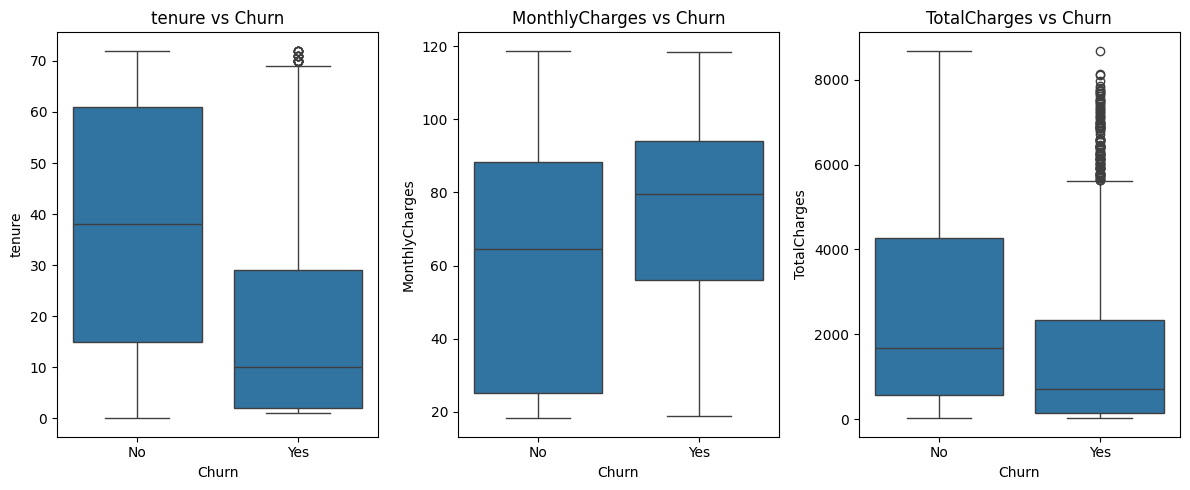

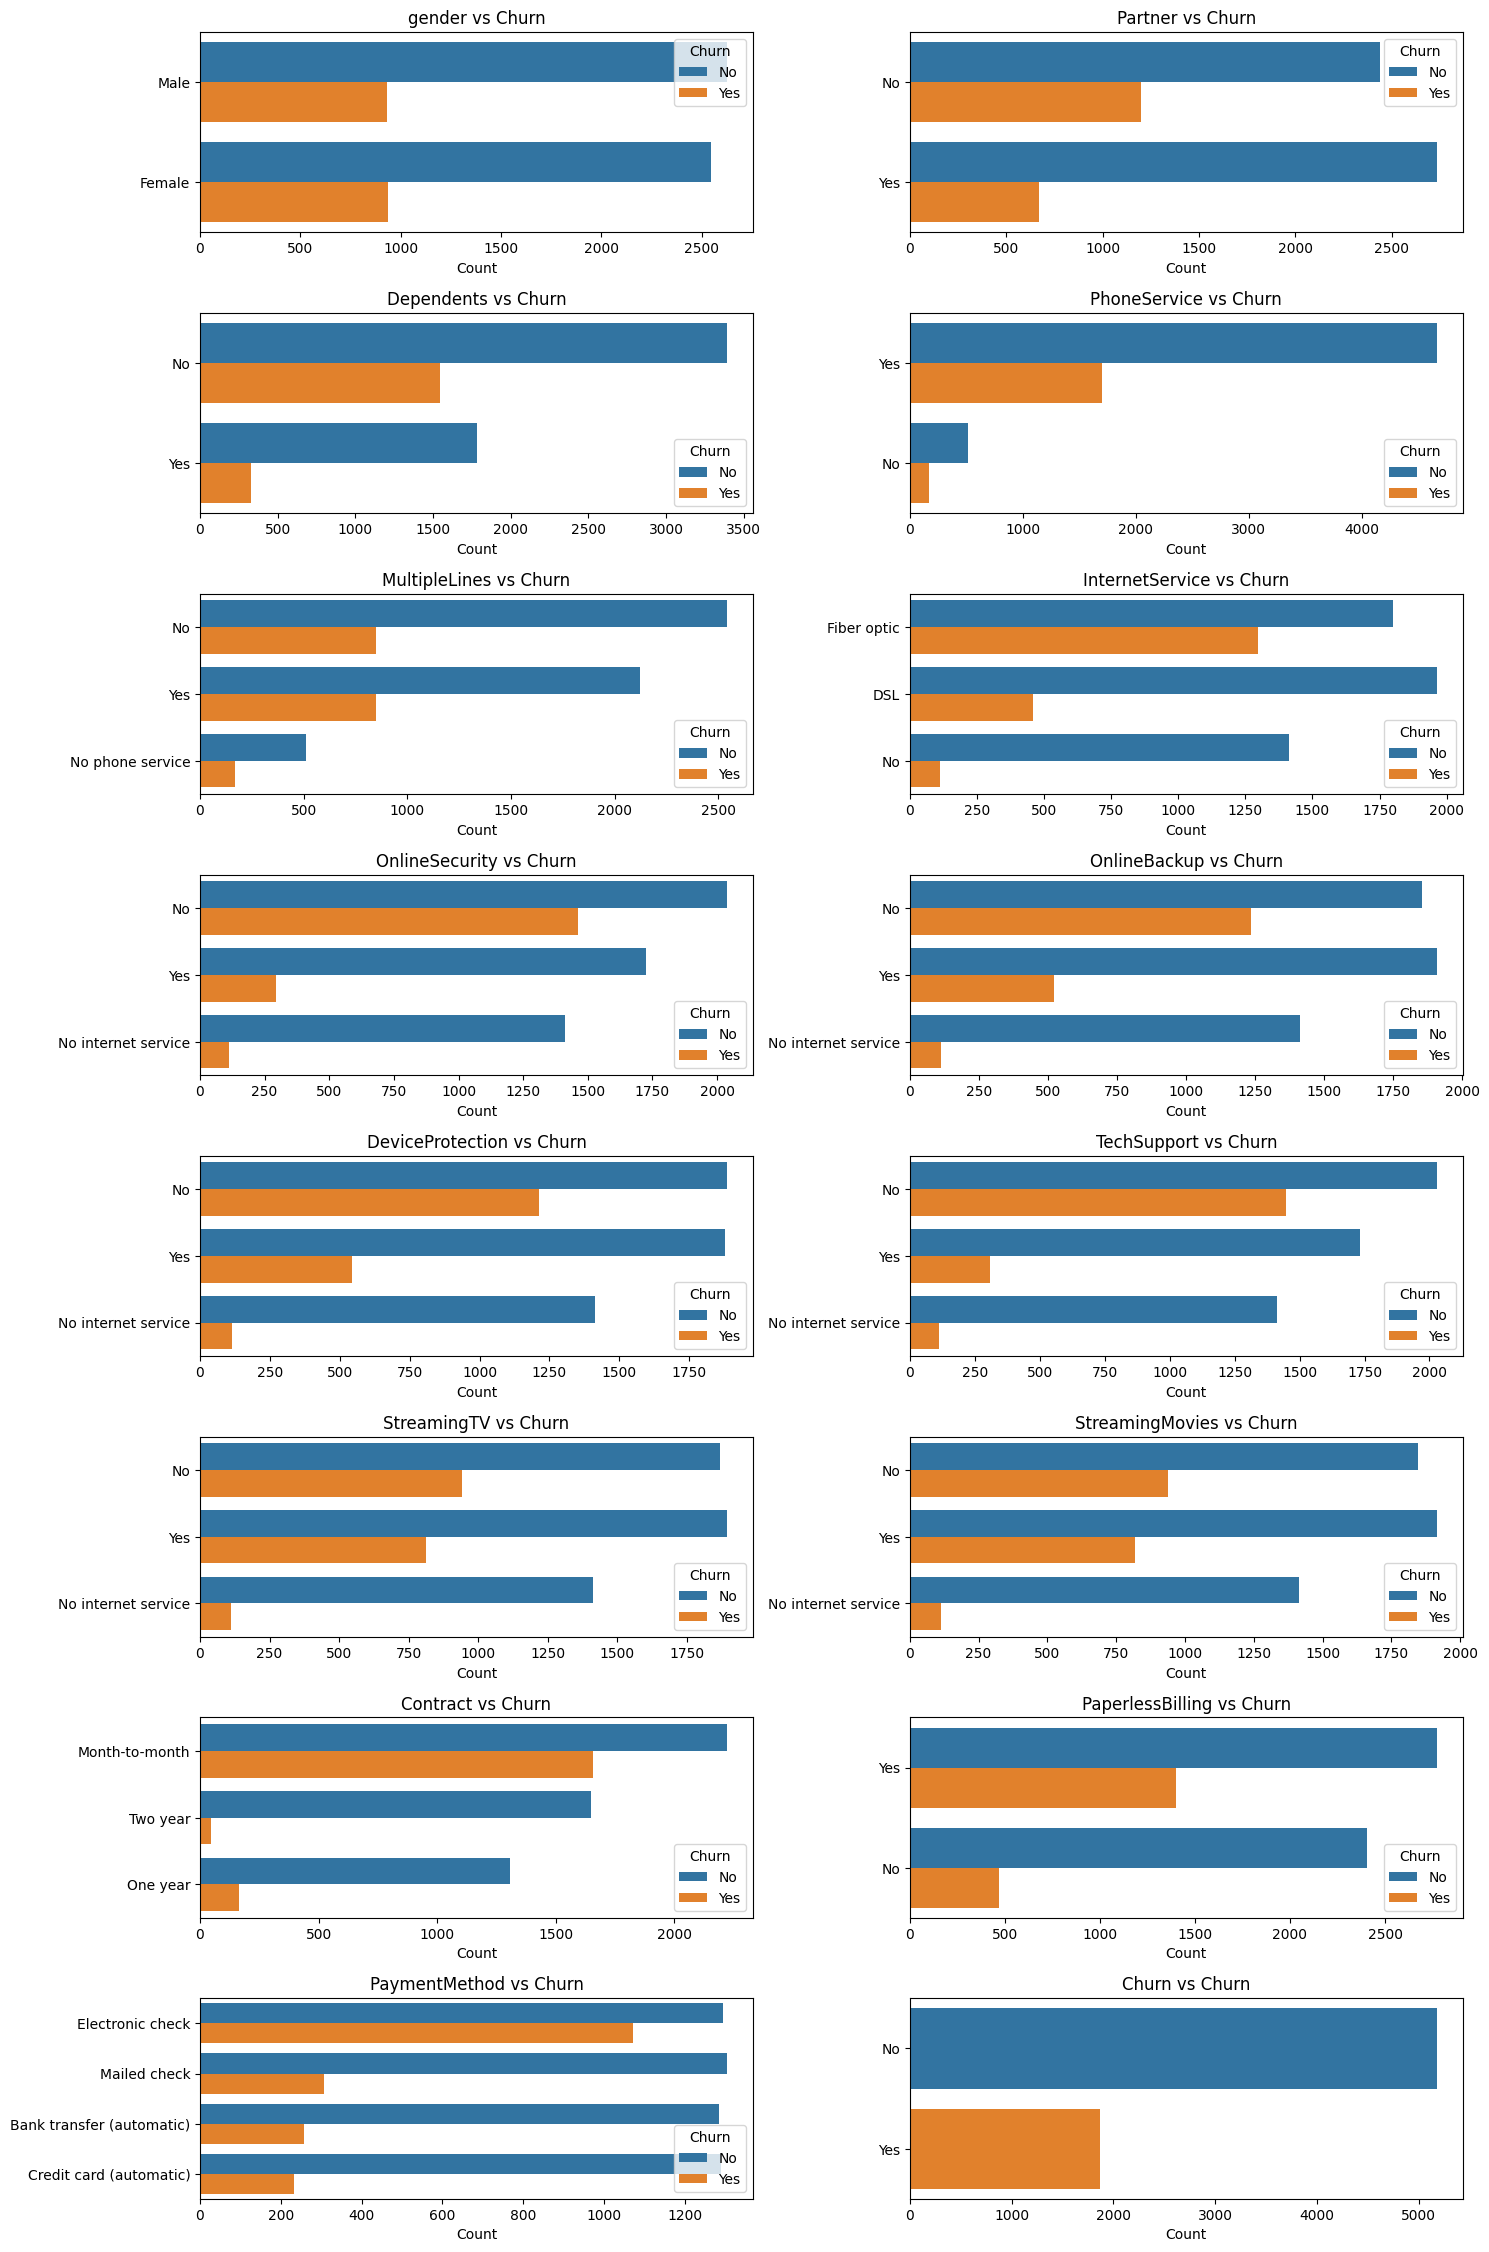

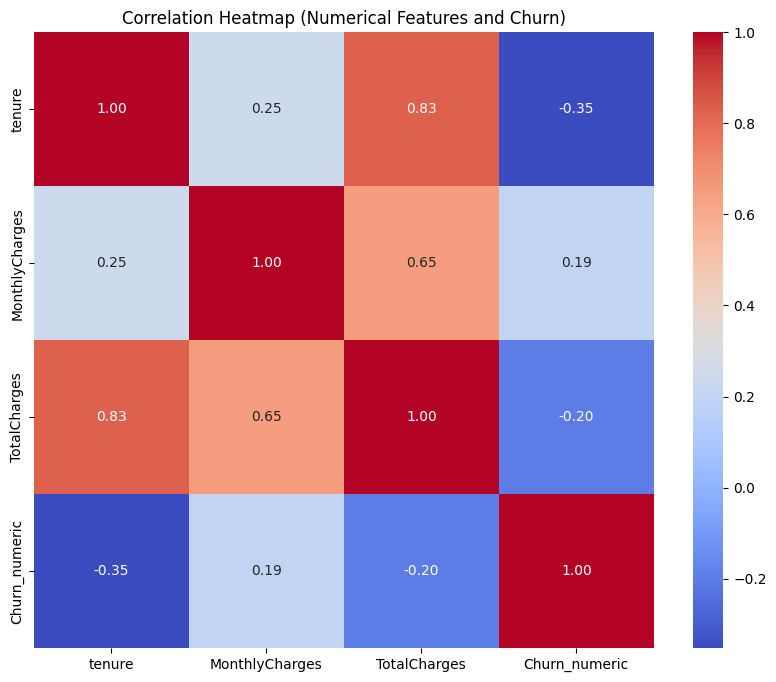

In [40]:
# Numerical features vs. Churn
plt.figure(figsize=(12, 5))
for i, col in enumerate(numerical_features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(data=df, x='Churn', y=col)
    plt.title(f'{col} vs Churn')
plt.tight_layout()
plt.show()

# Categorical features vs. Churn
plt.figure(figsize=(15, 25)) # Adjust figsize
for i, col in enumerate(categorical_features):
     plt.subplot(len(categorical_features)//2 + 1, 2, i+1)
     sns.countplot(data=df, y=col, hue='Churn', order=df[col].value_counts().index)
     plt.title(f'{col} vs Churn')
     plt.xlabel('Count')
     plt.ylabel('')
plt.tight_layout()
plt.show()

# Correlation Heatmap (only numerical features after encoding)
# We'll do this properly after preprocessing, but can get an initial idea
# Convert Churn to numeric for correlation calc
df_corr = df.copy()
df_corr['Churn_numeric'] = df_corr['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr[numerical_features + ['Churn_numeric']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap (Numerical Features and Churn)')
plt.show()

In [41]:
# Option 1: Impute with 0 (Recommended given the context of 0 tenure)
df['TotalCharges'].fillna(0, inplace=True)
# Option 2: Impute with median (Alternative)
# median_total_charges = df['TotalCharges'].median()
# df['TotalCharges'].fillna(median_total_charges, inplace=True)
print("\nMissing values after imputation:\n", df.isnull().sum())


Missing values after imputation:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [42]:
df.drop('customerID', axis=1, inplace=True)

In [43]:
# Convert Churn to numeric
# Make sure this is done only once and correctly
if df['Churn'].dtype == 'object':
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
    print("Mapped 'Churn' column to 0/1.")
else:
    print("'Churn' column is already numeric.")

# --- Verify Churn distribution after mapping ---
print("\nChurn Value Counts (After Mapping):\n", df['Churn'].value_counts(normalize=True))

Mapped 'Churn' column to 0/1.

Churn Value Counts (After Mapping):
 Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


In [44]:
# Tenure Groups (already done, ensure it's category type)
bins = [0, 12, 24, 36, 48, 60, 100]
labels = ['0-1 Year', '1-2 Years', '2-3 Years', '3-4 Years', '4-5 Years', '5+ Years']
df['TenureGroup'] = pd.cut(df['tenure'], bins=bins, labels=labels, right=False, include_lowest=True).astype('category') # Explicitly set as category
print("Created 'TenureGroup' feature.")

# Number of Optional Services (already done)
optional_service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in optional_service_cols:
    df[col + '_numeric'] = df[col].map({'Yes': 1, 'No': 0, 'No internet service': 0})
df['NumOptionalServices'] = df[[col + '_numeric' for col in optional_service_cols]].sum(axis=1)
df.drop([col + '_numeric' for col in optional_service_cols], axis=1, inplace=True)
print("Created 'NumOptionalServices' feature.")

# Payment Method Type (already done, ensure it's category type)
payment_map_simple = { 'Bank transfer (automatic)': 'Automatic', 'Credit card (automatic)': 'Automatic', 'Mailed check': 'Manual', 'Electronic check': 'Manual'}
df['PaymentMethodType'] = df['PaymentMethod'].map(payment_map_simple).astype('category') # Explicitly set as category
print("Created 'PaymentMethodType' feature.")

# New Interaction: Tenure * MonthlyCharges
df['Tenure_x_Monthly'] = df['tenure'] * df['MonthlyCharges']
print("Created 'Tenure_x_Monthly' interaction feature.")

# New Interaction: Senior Citizen with Fiber Optic
df['Senior_Fiber'] = ((df['SeniorCitizen'] == 1) & (df['InternetService'] == 'Fiber optic')).astype(int)
print("Created 'Senior_Fiber' interaction flag.")

# New Ratio: Monthly Charges per Tenure (handle tenure=0)
# Adding a small epsilon to avoid division by zero, or impute based on logic
df['Monthly_per_Tenure'] = df['MonthlyCharges'] / (df['tenure'] + 1e-6) # Add small epsilon
# Or handle differently: df['Monthly_per_Tenure'] = np.where(df['tenure'] == 0, 0, df['MonthlyCharges'] / df['tenure'])
print("Created 'Monthly_per_Tenure' ratio feature.")

# New Flag: High Monthly Charges (e.g., > 80 percentile)
high_charge_threshold = df['MonthlyCharges'].quantile(0.80)
df['HighMonthlyCharge'] = (df['MonthlyCharges'] > high_charge_threshold).astype(int)
print(f"Created 'HighMonthlyCharge' flag (threshold > {high_charge_threshold:.2f}).")

Created 'TenureGroup' feature.
Created 'NumOptionalServices' feature.
Created 'PaymentMethodType' feature.
Created 'Tenure_x_Monthly' interaction feature.
Created 'Senior_Fiber' interaction flag.
Created 'Monthly_per_Tenure' ratio feature.
Created 'HighMonthlyCharge' flag (threshold > 94.25).


In [45]:
# --- Final Check After Feature Engineering ---
print("\nDataFrame shape after Feature Engineering:", df.shape)
print("Columns:", df.columns.tolist())
print("\nChurn Value Counts (After Feature Engineering):\n", df['Churn'].value_counts(normalize=True))
if df['Churn'].nunique() < 2:
    raise ValueError("Churn column only has one class after feature engineering!")


DataFrame shape after Feature Engineering: (7043, 27)
Columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'TenureGroup', 'NumOptionalServices', 'PaymentMethodType', 'Tenure_x_Monthly', 'Senior_Fiber', 'Monthly_per_Tenure', 'HighMonthlyCharge']

Churn Value Counts (After Feature Engineering):
 Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


In [46]:
# Separate features (X) and target (y) AFTER all feature engineering
X = df.drop('Churn', axis=1)
y = df['Churn']

# --- CRITICAL CHECK ---
print("\nChurn Value Counts in y (Immediately Before Split):\n", y.value_counts(normalize=True))
if y.nunique() < 2:
     raise ValueError("Error: Target variable 'y' has only one class before splitting.")

# Identify column types AFTER feature engineering
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove original columns replaced by engineered features if they linger
if 'PaymentMethod' in categorical_cols:
    categorical_cols.remove('PaymentMethod')
    if 'PaymentMethod' in X.columns:
         X.drop('PaymentMethod', axis=1, inplace=True)
         print("Dropped original 'PaymentMethod' column.")
if 'PaymentMethod' in numerical_cols: # Should not happen, but check
    numerical_cols.remove('PaymentMethod')


# Ensure column lists only contain columns present in X
numerical_cols = [col for col in numerical_cols if col in X.columns]
categorical_cols = [col for col in categorical_cols if col in X.columns]

print("\nNumerical columns identified:", numerical_cols)
print("Categorical columns identified:", categorical_cols)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nData split into train/test: Train={X_train.shape}, Test={X_test.shape}")

# --- Final Verification ---
print("\nChurn distribution in y_train (After Split):\n", y_train.value_counts(normalize=True))
print("\nChurn distribution in y_test (After Split):\n", y_test.value_counts(normalize=True))
if y_train.nunique() < 2 or y_test.nunique() < 2:
    print("\nWarning: Stratification failed or input 'y' was single-class.")


Churn Value Counts in y (Immediately Before Split):
 Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64
Dropped original 'PaymentMethod' column.

Numerical columns identified: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'NumOptionalServices', 'Tenure_x_Monthly', 'Senior_Fiber', 'Monthly_per_Tenure', 'HighMonthlyCharge']
Categorical columns identified: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'TenureGroup', 'PaymentMethodType']

Data split into train/test: Train=(5634, 25), Test=(1409, 25)

Churn distribution in y_train (After Split):
 Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64

Churn distribution in y_test (After Split):
 Churn
0    0.734564
1    0.265436
Name: proportion, dtype: float64


In [47]:
# --- 4. Preprocessing Pipeline Definition ---
print("\n--- 4. Preprocessing Pipeline Definition ---")

# Create preprocessing steps
numeric_transformer = StandardScaler()
# CatBoost handles categories, so we might create a separate preprocessor for it later if needed
# For others, use OneHotEncoder
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False) # sparse=False might help some models/SHAP

# Create the ColumnTransformer
# Ensure numerical_cols and categorical_cols are correct from the previous step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

# Fit the preprocessor and get column names (important for interpretation)
print("Fitting preprocessor on X_train...")
preprocessor.fit(X_train)
print("Preprocessor fitted.")

try:
    model_columns = preprocessor.get_feature_names_out().tolist()
    print(f"Number of features after preprocessing: {len(model_columns)}")
    with open('model_columns.txt', 'w') as f:
        for col_name in model_columns:
            f.write(f"{col_name}\n")
    print("Model columns saved to model_columns.txt")
except Exception as e:
    print(f"Error getting/saving feature names: {e}")
    model_columns = None # Handle this downstream if names are crucial


--- 4. Preprocessing Pipeline Definition ---
Fitting preprocessor on X_train...
Preprocessor fitted.
Number of features after preprocessing: 38
Model columns saved to model_columns.txt


In [48]:
# --- 5. Model Pipeline Definitions (SMOTE vs Class Weight) & Hyperparameter Grids ---
print("\n--- 5. Model Pipeline Definitions & Hyperparameter Grids ---")

# --- Option A: Pipelines WITH SMOTE ---
lr_smote = LogisticRegression(random_state=42, max_iter=2000, solver='liblinear') # liblinear often good for high dim
rf_smote = RandomForestClassifier(random_state=42)
xgb_smote = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
lgbm_smote = LGBMClassifier(random_state=42, objective='binary')
# CatBoost handles categories internally, less ideal in this specific pipeline structure with OHE first
# If using CatBoost, often better to pipeline it differently or pass categorical indices

pipeline_lr_smote = ImbPipeline([('preprocess', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', lr_smote)])
pipeline_rf_smote = ImbPipeline([('preprocess', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', rf_smote)])
pipeline_xgb_smote = ImbPipeline([('preprocess', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', xgb_smote)])
pipeline_lgbm_smote = ImbPipeline([('preprocess', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', lgbm_smote)])

# --- Option B: Pipelines WITHOUT SMOTE, using Class Weights ---
# Calculate scale_pos_weight for XGB/LGBM
spw = sum(y_train == 0) / sum(y_train == 1) if sum(y_train == 1) > 0 else 1
print(f"Calculated scale_pos_weight: {spw:.2f}")

lr_cw = LogisticRegression(random_state=42, max_iter=2000, class_weight='balanced', solver='liblinear')
rf_cw = RandomForestClassifier(random_state=42, class_weight='balanced')
xgb_cw = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=spw)
lgbm_cw = LGBMClassifier(random_state=42, objective='binary', class_weight='balanced') # LGBM uses class_weight

pipeline_lr_cw = Pipeline([('preprocess', preprocessor), ('classifier', lr_cw)]) # Use sklearn Pipeline
pipeline_rf_cw = Pipeline([('preprocess', preprocessor), ('classifier', rf_cw)])
pipeline_xgb_cw = Pipeline([('preprocess', preprocessor), ('classifier', xgb_cw)])
pipeline_lgbm_cw = Pipeline([('preprocess', preprocessor), ('classifier', lgbm_cw)])

# --- Expanded Parameter Grids for RandomizedSearchCV ---
# Note: These are examples, adjust based on computational resources and desired search breadth
param_dist_lr = {'classifier__C': np.logspace(-2, 2, 10)} # Wider C range

param_dist_rf = {'classifier__n_estimators': [100, 200, 300, 400],
                 'classifier__max_depth': [10, 15, 20, None],
                 'classifier__min_samples_split': [5, 10, 15],
                 'classifier__min_samples_leaf': [3, 5, 7],
                 'classifier__max_features': ['sqrt', 'log2', None]} # Added max_features

param_dist_xgb = {'classifier__n_estimators': [100, 200, 300, 400],
                  'classifier__max_depth': [3, 5, 7, 9],
                  'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
                  'classifier__subsample': [0.7, 0.8, 0.9, 1.0],
                  'classifier__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
                  'classifier__gamma': [0, 0.1, 0.2, 0.3]}

param_dist_lgbm = {'classifier__n_estimators': [100, 200, 300, 400],
                   'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
                   'classifier__num_leaves': [20, 31, 40, 50],
                   'classifier__max_depth': [-1, 10, 15, 20],
                   'classifier__colsample_bytree': [0.7, 0.8, 0.9],
                   'classifier__reg_alpha': [0, 0.1, 0.5], # L1 reg
                   'classifier__reg_lambda': [0, 0.1, 0.5]} # L2 reg

print("Pipeline and parameter distributions defined for SMOTE and Class Weight approaches.")


--- 5. Model Pipeline Definitions & Hyperparameter Grids ---
Calculated scale_pos_weight: 2.77
Pipeline and parameter distributions defined for SMOTE and Class Weight approaches.


In [49]:
print("Original y_train distribution:\n", y_train.value_counts())
print(f"Minority class percentage: {y_train.mean() * 100:.2f}%")

Original y_train distribution:
 Churn
0    4139
1    1495
Name: count, dtype: int64
Minority class percentage: 26.54%


In [50]:
# --- 6. Hyperparameter Tuning (Using RandomizedSearchCV for Accuracy) ---
# (Assuming previous setup cells are run, including pipeline definitions and param grids)
from sklearn.model_selection import RandomizedSearchCV, ParameterGrid
from sklearn.exceptions import NotFittedError

print("\n--- 6. Hyperparameter Tuning (Accuracy Focus) ---")

# Settings for RandomizedSearchCV
n_iter_search = 30 # Number of parameter settings sampled
cv_folds = 5       # Number of cross-validation folds
scoring_metric_acc = 'accuracy'

# --- Dictionary to store best pipelines ---
best_pipelines = {}
best_cv_scores = {} # Store CV scores as well

# --- Tune SMOTE Pipelines ---
print("\n--- Tuning SMOTE Pipelines ---")
pipelines_smote = {
    'LR_SMOTE': (pipeline_lr_smote, param_dist_lr),
    'RF_SMOTE': (pipeline_rf_smote, param_dist_rf),
    'XGB_SMOTE': (pipeline_xgb_smote, param_dist_xgb),
    'LGBM_SMOTE': (pipeline_lgbm_smote, param_dist_lgbm)
}

for name, (pipeline, param_dist) in pipelines_smote.items():
    print(f"\nTuning {name}...")
    # Adjust n_iter based on param space size
    grid_size = len(ParameterGrid(param_dist))
    current_n_iter = min(n_iter_search, grid_size) if grid_size > 0 else 1

    random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist,
                                       n_iter=current_n_iter, cv=cv_folds,
                                       scoring=scoring_metric_acc, n_jobs=-1,
                                       random_state=42, error_score='raise')
    try:
        random_search.fit(X_train, y_train) # Perform the actual tuning
        print(f"Best {name} Params: {random_search.best_params_}")
        print(f"Best {name} CV Score ({scoring_metric_acc}): {random_search.best_score_:.4f}")
        best_pipelines[name] = random_search.best_estimator_ # Store the best fitted pipeline
        best_cv_scores[name] = random_search.best_score_
    except ValueError as ve:
        print(f"Skipping {name} due to ValueError during setup/fit: {ve}")
    except Exception as e:
        print(f"An error occurred during tuning for {name}: {e}")


# --- Tune Class Weight Pipelines ---
print("\n--- Tuning Class Weight Pipelines ---")
pipelines_cw = {
    'LR_CW': (pipeline_lr_cw, param_dist_lr),
    'RF_CW': (pipeline_rf_cw, param_dist_rf),
    'XGB_CW': (pipeline_xgb_cw, param_dist_xgb),
    'LGBM_CW': (pipeline_lgbm_cw, param_dist_lgbm)
}

for name, (pipeline, param_dist) in pipelines_cw.items():
    print(f"\nTuning {name}...")
    grid_size = len(ParameterGrid(param_dist))
    current_n_iter = min(n_iter_search, grid_size) if grid_size > 0 else 1

    random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist,
                                       n_iter=current_n_iter, cv=cv_folds,
                                       scoring=scoring_metric_acc, n_jobs=-1,
                                       random_state=42, error_score='raise')
    try:
        random_search.fit(X_train, y_train) # Perform the actual tuning
        print(f"Best {name} Params: {random_search.best_params_}")
        print(f"Best {name} CV Score ({scoring_metric_acc}): {random_search.best_score_:.4f}")
        best_pipelines[name] = random_search.best_estimator_ # Store the best fitted pipeline
        best_cv_scores[name] = random_search.best_score_
    except ValueError as ve:
        print(f"Skipping {name} due to ValueError during setup/fit: {ve}")
    except Exception as e:
        print(f"An error occurred during tuning for {name}: {e}")


print(f"\nHyperparameter tuning complete. Found {len(best_pipelines)} fitted best pipelines.")

# --- Verify best CV scores match your output (adjust if needed) ---
print("\n--- Summary of Best CV Scores (Accuracy) ---")
for name, score in best_cv_scores.items():
    print(f"{name}: {score:.4f}")


--- 6. Hyperparameter Tuning (Accuracy Focus) ---

--- Tuning SMOTE Pipelines ---

Tuning LR_SMOTE...
Best LR_SMOTE Params: {'classifier__C': np.float64(0.01)}
Best LR_SMOTE CV Score (accuracy): 0.7584

Tuning RF_SMOTE...
Best LR_SMOTE Params: {'classifier__C': np.float64(0.01)}
Best LR_SMOTE CV Score (accuracy): 0.7584

Tuning RF_SMOTE...
Best RF_SMOTE Params: {'classifier__n_estimators': 400, 'classifier__min_samples_split': 15, 'classifier__min_samples_leaf': 3, 'classifier__max_features': 'sqrt', 'classifier__max_depth': None}
Best RF_SMOTE CV Score (accuracy): 0.7886

Tuning XGB_SMOTE...
Best RF_SMOTE Params: {'classifier__n_estimators': 400, 'classifier__min_samples_split': 15, 'classifier__min_samples_leaf': 3, 'classifier__max_features': 'sqrt', 'classifier__max_depth': None}
Best RF_SMOTE CV Score (accuracy): 0.7886

Tuning XGB_SMOTE...
Best XGB_SMOTE Params: {'classifier__subsample': 1.0, 'classifier__n_estimators': 200, 'classifier__max_depth': 5, 'classifier__learning_rate


--- 7. Model Evaluation (Accuracy Focus) ---

--- Evaluating Tuned Models on Test Set ---

--- Evaluating LR_SMOTE ---
Accuracy: 0.7395
ROC AUC: 0.8390
Classification Report:
               precision    recall  f1-score   support

    No Churn       0.90      0.72      0.80      1035
       Churn       0.51      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



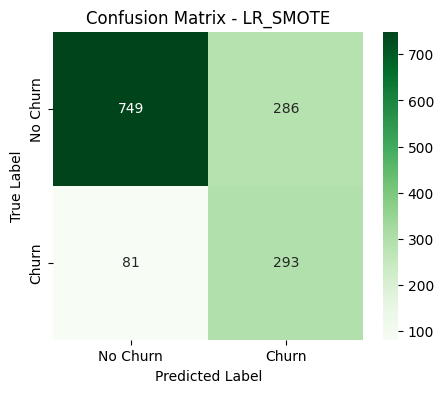


--- Evaluating RF_SMOTE ---
Accuracy: 0.7800
ROC AUC: 0.8367
Classification Report:
               precision    recall  f1-score   support

    No Churn       0.87      0.82      0.85      1035
       Churn       0.57      0.67      0.62       374

    accuracy                           0.78      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.79      0.78      0.79      1409

Accuracy: 0.7800
ROC AUC: 0.8367
Classification Report:
               precision    recall  f1-score   support

    No Churn       0.87      0.82      0.85      1035
       Churn       0.57      0.67      0.62       374

    accuracy                           0.78      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.79      0.78      0.79      1409



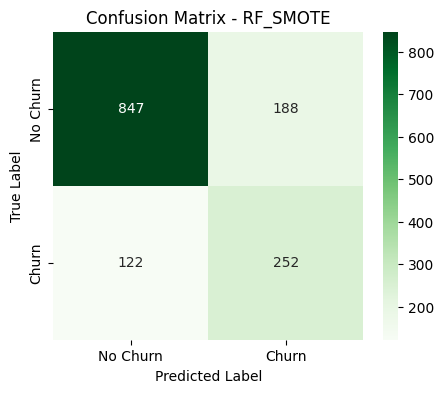


--- Evaluating XGB_SMOTE ---
Accuracy: 0.7786
ROC AUC: 0.8367
Classification Report:
               precision    recall  f1-score   support

    No Churn       0.86      0.83      0.85      1035
       Churn       0.58      0.63      0.60       374

    accuracy                           0.78      1409
   macro avg       0.72      0.73      0.72      1409
weighted avg       0.79      0.78      0.78      1409



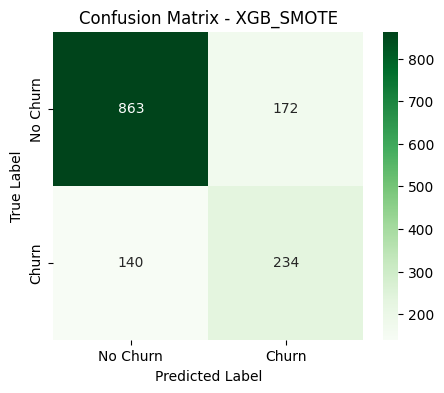


--- Evaluating LGBM_SMOTE ---
Accuracy: 0.7885
ROC AUC: 0.8363
Classification Report:
               precision    recall  f1-score   support

    No Churn       0.85      0.86      0.86      1035
       Churn       0.60      0.59      0.60       374

    accuracy                           0.79      1409
   macro avg       0.73      0.73      0.73      1409
weighted avg       0.79      0.79      0.79      1409



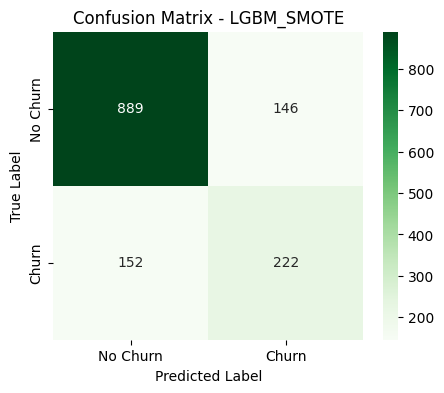


--- Evaluating LR_CW ---
Accuracy: 0.7367
ROC AUC: 0.8405
Classification Report:
               precision    recall  f1-score   support

    No Churn       0.90      0.72      0.80      1035
       Churn       0.50      0.79      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



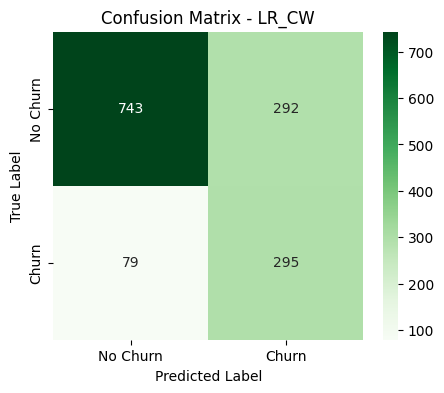


--- Evaluating RF_CW ---
Accuracy: 0.7750
ROC AUC: 0.8241
Classification Report:
               precision    recall  f1-score   support

    No Churn       0.86      0.83      0.84      1035
       Churn       0.57      0.62      0.59       374

    accuracy                           0.78      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.78      0.78      0.78      1409



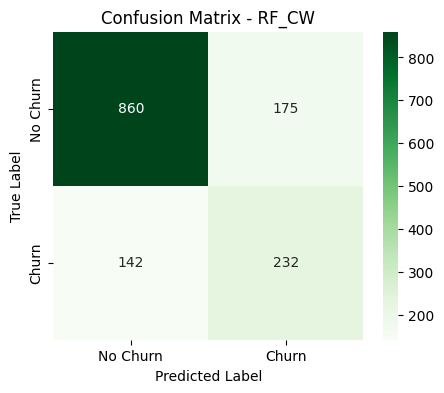


--- Evaluating XGB_CW ---
Accuracy: 0.7686
ROC AUC: 0.8200
Classification Report:
               precision    recall  f1-score   support

    No Churn       0.86      0.81      0.84      1035
       Churn       0.56      0.64      0.60       374

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.78      0.77      0.77      1409



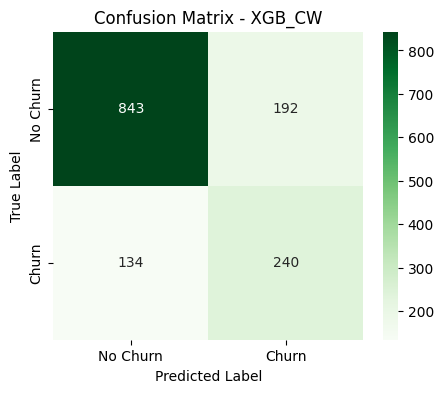


--- Evaluating LGBM_CW ---
Accuracy: 0.7658
ROC AUC: 0.8270
Classification Report:
               precision    recall  f1-score   support

    No Churn       0.88      0.79      0.83      1035
       Churn       0.55      0.69      0.61       374

    accuracy                           0.77      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.77      0.77      1409



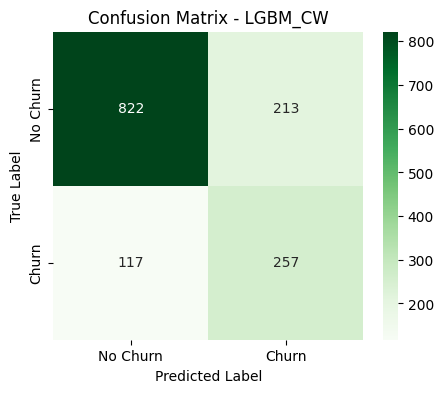


--- ROC Curve Comparison (Test Set) ---


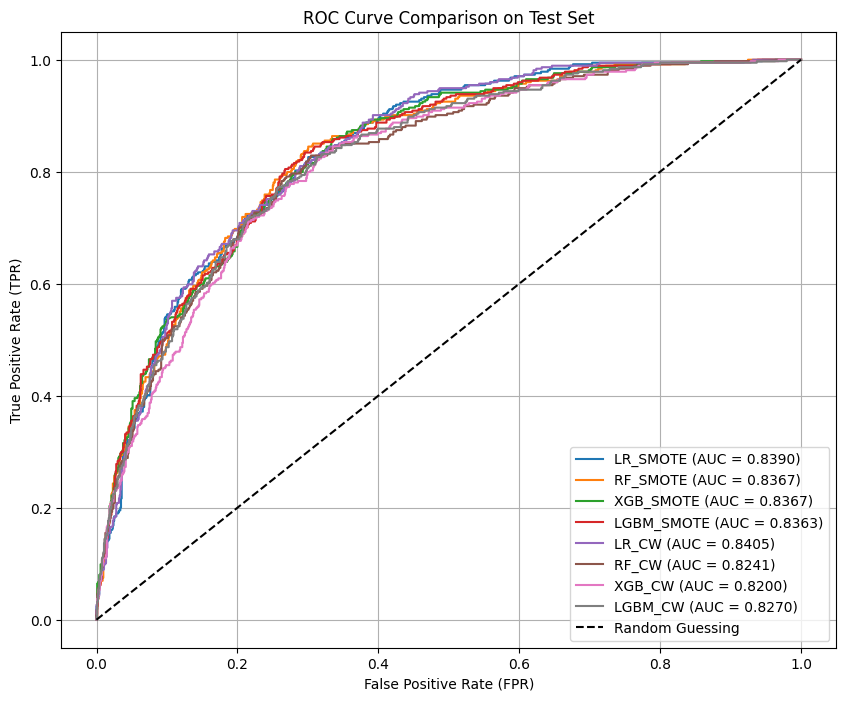


--- Model Selection based on Test Set Accuracy ---
LGBM_SMOTE: Accuracy = 0.7885, ROC AUC = 0.8363
RF_SMOTE: Accuracy = 0.7800, ROC AUC = 0.8367
XGB_SMOTE: Accuracy = 0.7786, ROC AUC = 0.8367
RF_CW: Accuracy = 0.7750, ROC AUC = 0.8241
XGB_CW: Accuracy = 0.7686, ROC AUC = 0.8200
LGBM_CW: Accuracy = 0.7658, ROC AUC = 0.8270
LR_SMOTE: Accuracy = 0.7395, ROC AUC = 0.8390
LR_CW: Accuracy = 0.7367, ROC AUC = 0.8405

Selected Best Individual Model (Accuracy): LGBM_SMOTE with Accuracy: 0.7885


In [54]:
# --- 7. Model Evaluation (Accuracy Focus) ---
print("\n--- 7. Model Evaluation (Accuracy Focus) ---")
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Ensure pandas is imported

results_acc = {}
predictions_acc = {}

print("\n--- Evaluating Tuned Models on Test Set ---")
# Use the 'best_pipelines' dictionary which now contains FITTED pipelines
for name, pipeline in best_pipelines.items():
    # Double-check if fitting actually happened (e.g., if an error occurred above)
    # A simple check is if the final estimator step has the 'classes_' attribute
    try:
        _ = pipeline.steps[-1][1].classes_ # Access final estimator's attribute
        is_fitted = True
    except (AttributeError, NotFittedError):
        is_fitted = False
        print(f"\nSkipping evaluation for {name} as it doesn't appear to be fitted.")

    if is_fitted:
        print(f"\n--- Evaluating {name} ---")
        try:
            y_pred = pipeline.predict(X_test)
            # Use try-except for predict_proba as some models might not support it well
            try:
                y_pred_proba = pipeline.predict_proba(X_test)[:, 1] # Probability of Churn (class 1)
                roc_auc = roc_auc_score(y_test, y_pred_proba)
            except AttributeError:
                print(f"Warning: predict_proba not available for {name}. ROC AUC set to N/A.")
                y_pred_proba = None # Or handle differently, e.g., use decision_function if available
                roc_auc = np.nan # Not applicable

            predictions_acc[name] = y_pred

            acc = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred, target_names=['No Churn', 'Churn'])
            cm = confusion_matrix(y_test, y_pred)

            results_acc[name] = {'accuracy': acc, 'roc_auc': roc_auc, 'report': report, 'confusion_matrix': cm, 'pipeline': pipeline}

            print(f"Accuracy: {acc:.4f}")
            if not np.isnan(roc_auc):
                print(f"ROC AUC: {roc_auc:.4f}")
            print("Classification Report:\n", report)

            # Visualize Confusion Matrix
            plt.figure(figsize=(5, 4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
            plt.title(f'Confusion Matrix - {name}')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()
        except Exception as eval_e:
            print(f"Error during evaluation for {name}: {eval_e}")


# --- ROC Curve Comparison (Still useful context) ---
if results_acc: # Only plot if there are results
    print("\n--- ROC Curve Comparison (Test Set) ---")
    plt.figure(figsize=(10, 8))
    plotted_roc = False
    for name, result in results_acc.items():
        pipeline = result['pipeline']
        roc_auc = result['roc_auc']
        # Check if AUC is valid before plotting
        if not np.isnan(roc_auc):
            try:
                y_pred_proba = pipeline.predict_proba(X_test)[:, 1] # Recalculate for safety
                fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
                plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')
                plotted_roc = True
            except Exception as e:
                print(f"Could not plot ROC for {name}: {e}")

    if plotted_roc:
        plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('ROC Curve Comparison on Test Set')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("\nNo valid ROC AUC scores available to plot ROC curves.")
else:
    print("\nNo fitted models to evaluate or plot ROC curves for.")


# --- Select Best Model Based on Accuracy ---
best_model_name_acc = None
best_accuracy = -1

if results_acc:
    print("\n--- Model Selection based on Test Set Accuracy ---")
    # Sort results by accuracy
    sorted_results = sorted(results_acc.items(), key=lambda item: item[1]['accuracy'], reverse=True)

    for name, result in sorted_results:
        roc_auc_display = f"{result['roc_auc']:.4f}" if not np.isnan(result['roc_auc']) else "N/A"
        print(f"{name}: Accuracy = {result['accuracy']:.4f}, ROC AUC = {roc_auc_display}")

    # The best model is the first one in the sorted list
    best_model_name_acc = sorted_results[0][0]
    best_accuracy = sorted_results[0][1]['accuracy']
    final_pipeline_individual = results_acc[best_model_name_acc]['pipeline'] # Get the pipeline object
    print(f"\nSelected Best Individual Model (Accuracy): {best_model_name_acc} with Accuracy: {best_accuracy:.4f}")
else:
    print("\nNo models evaluated, cannot select best model.")
    final_pipeline_individual = None # Explicitly set to None


--- 8. Ensemble Model (Voting Classifier using Top 3) ---
Selected estimators for Voting Classifier: ['LGBM_SMOTE', 'RF_SMOTE', 'XGB_SMOTE']
Fitting Voting Classifier on the full training data...

--- Evaluating Voting Classifier on Test Set ---

--- Evaluating Voting Classifier on Test Set ---
Voting Classifier Accuracy: 0.7800
Voting Classifier ROC AUC: 0.8376
Voting Classifier Classification Report:
               precision    recall  f1-score   support

    No Churn       0.86      0.84      0.85      1035
       Churn       0.58      0.62      0.60       374

    accuracy                           0.78      1409
   macro avg       0.72      0.73      0.72      1409
weighted avg       0.78      0.78      0.78      1409

Voting Classifier Accuracy: 0.7800
Voting Classifier ROC AUC: 0.8376
Voting Classifier Classification Report:
               precision    recall  f1-score   support

    No Churn       0.86      0.84      0.85      1035
       Churn       0.58      0.62      0.60  

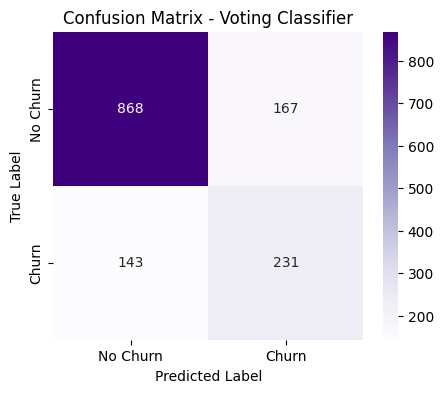


Best individual model performs better or equal to Voting Classifier.

--- Final Selected Model: LGBM_SMOTE ---
--- Final Test Accuracy: 0.7885 ---


In [55]:
# --- 8. Ensemble Model (Voting Classifier - Optional but Recommended) ---

# Select top N models based on test accuracy from results_acc
N_top_models = 3
if results_acc and len(results_acc) >= N_top_models:
    print(f"\n--- 8. Ensemble Model (Voting Classifier using Top {N_top_models}) ---")

    # Sort models by accuracy
    sorted_models = sorted(results_acc.items(), key=lambda item: item[1]['accuracy'], reverse=True)

    # Select top N pipelines for the ensemble
    top_estimators_list = [(name, result['pipeline']) for name, result in sorted_models[:N_top_models]]
    print("Selected estimators for Voting Classifier:", [name for name, _ in top_estimators_list])

    # Create and fit the Voting Classifier
    # Ensure the base estimators (pipelines) are already fitted
    voting_clf_acc = VotingClassifier(estimators=top_estimators_list, voting='soft', n_jobs=-1) # Soft voting usually better

    print("Fitting Voting Classifier on the full training data...")
    # Note: Fitting the VotingClassifier itself doesn't re-tune the base models.
    # It learns how to combine the outputs of the already tuned pipelines.
    try:
        voting_clf_acc.fit(X_train, y_train) # Fit on the original training data

        # Evaluate the Voting Classifier
        print("\n--- Evaluating Voting Classifier on Test Set ---")
        y_pred_voting = voting_clf_acc.predict(X_test)
        y_pred_proba_voting = voting_clf_acc.predict_proba(X_test)[:, 1]

        acc_voting = accuracy_score(y_test, y_pred_voting)
        roc_auc_voting = roc_auc_score(y_test, y_pred_proba_voting)
        report_voting = classification_report(y_test, y_pred_voting, target_names=['No Churn', 'Churn'])
        cm_voting = confusion_matrix(y_test, y_pred_voting)

        print(f"Voting Classifier Accuracy: {acc_voting:.4f}")
        print(f"Voting Classifier ROC AUC: {roc_auc_voting:.4f}")
        print("Voting Classifier Classification Report:\n", report_voting)

        plt.figure(figsize=(5, 4))
        sns.heatmap(cm_voting, annot=True, fmt='d', cmap='Purples', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
        plt.title('Confusion Matrix - Voting Classifier')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

        # Decide if the Voting Classifier is the final model
        if acc_voting > best_accuracy:
            print("\nVoting Classifier performs better than the best individual model.")
            final_pipeline = voting_clf_acc
            best_model_name_final = "VotingClassifier"
            best_accuracy_final = acc_voting
        else:
            print("\nBest individual model performs better or equal to Voting Classifier.")
            final_pipeline = final_pipeline_individual
            best_model_name_final = best_model_name_acc
            best_accuracy_final = best_accuracy
    except Exception as e_vote:
        print(f"Error fitting or evaluating Voting Classifier: {e_vote}")
        print("Falling back to best individual model.")
        final_pipeline = final_pipeline_individual
        best_model_name_final = best_model_name_acc
        best_accuracy_final = best_accuracy

else:
    print("\nSkipping Voting Classifier (not enough models evaluated or results missing).")
    final_pipeline = final_pipeline_individual # Use the best individual model found
    best_model_name_final = best_model_name_acc
    best_accuracy_final = best_accuracy


print(f"\n--- Final Selected Model: {best_model_name_final} ---")
print(f"--- Final Test Accuracy: {best_accuracy_final:.4f} ---")


--- 9. Interpretation of Best Individual Model ---
Interpreting: LGBM_SMOTE


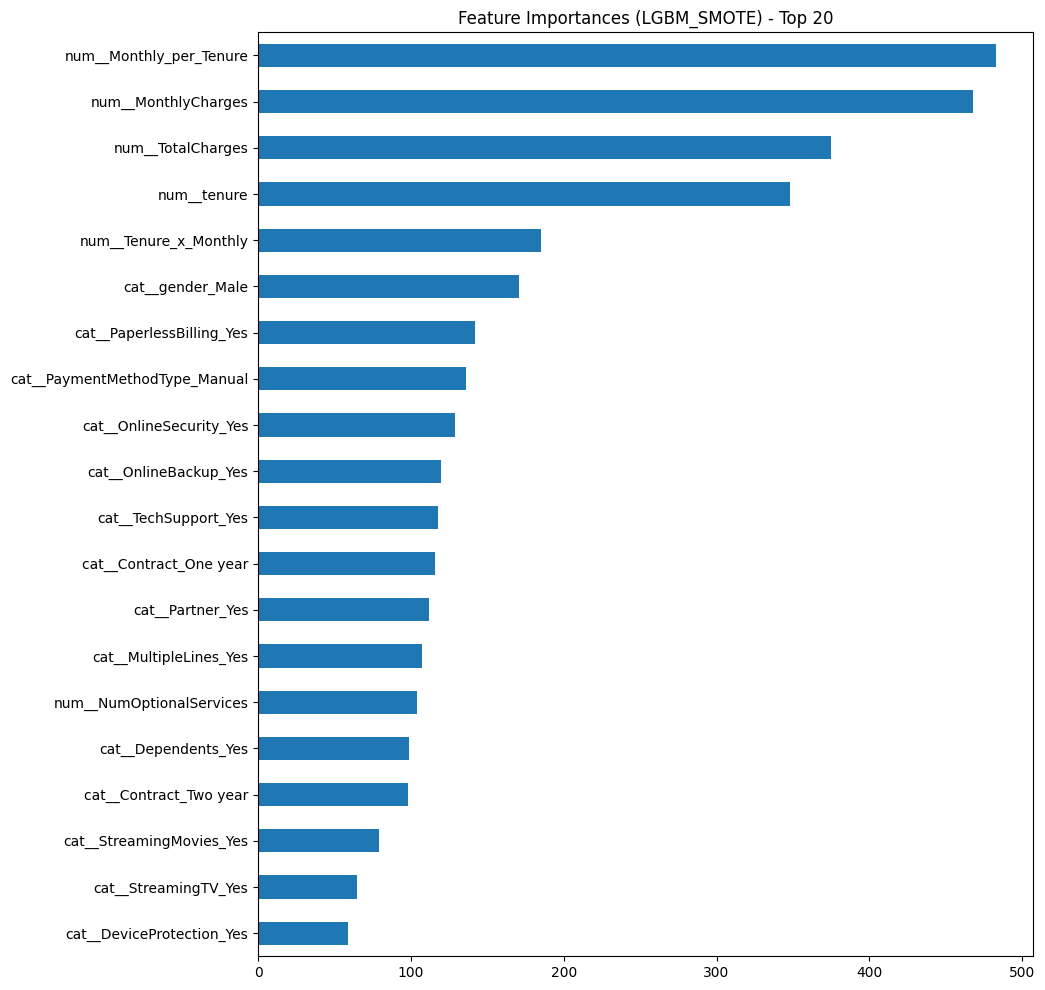


Calculating SHAP values for LGBM_SMOTE...

Generating SHAP Summary Plot (Beeswarm)...

Generating SHAP Summary Plot (Beeswarm)...


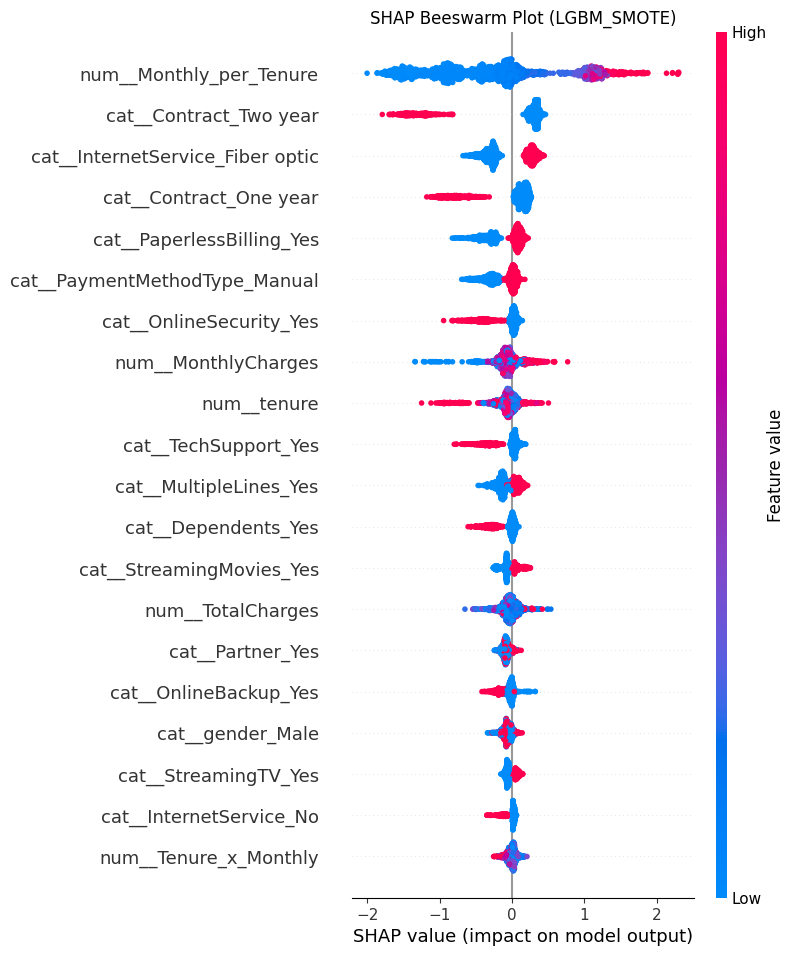


Generating SHAP Summary Plot (Bar)...


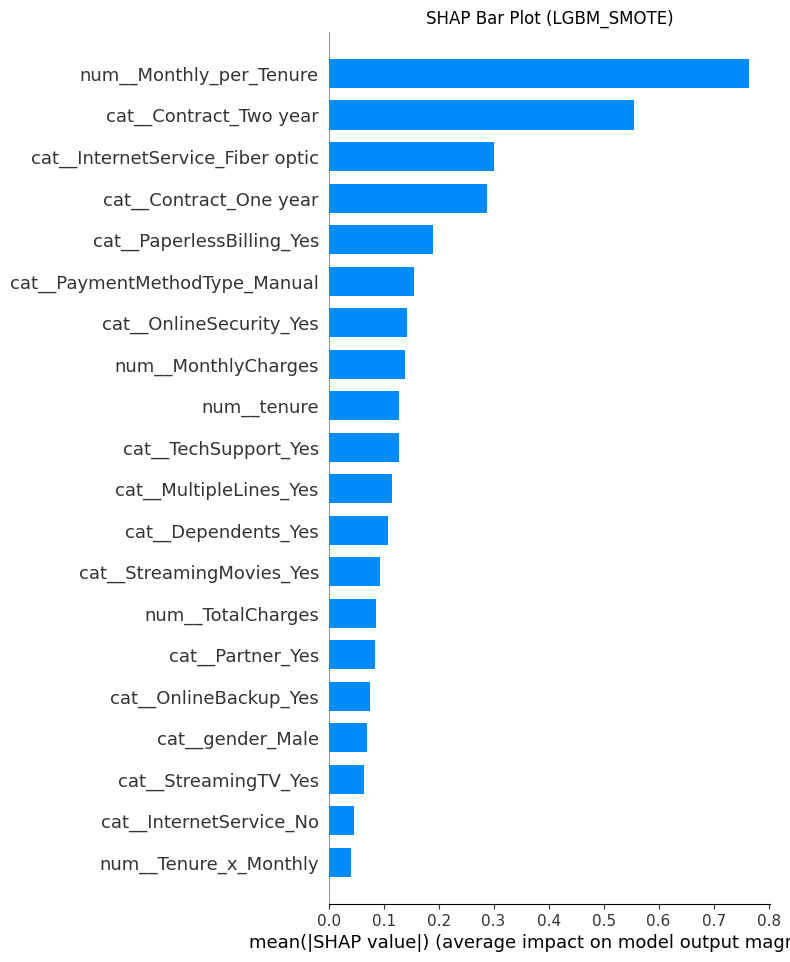

In [56]:
# --- 9. Final Model Interpretation (Interpret the BEST single model) ---
# Interpreting ensembles like VotingClassifier with SHAP is complex.
# It's often more practical to interpret the best-performing *individual* model.
# We'll use 'final_pipeline_individual' and 'best_model_name_acc' for this.

print("\n--- 9. Interpretation of Best Individual Model ---")

if final_pipeline_individual and best_model_name_acc:
    print(f"Interpreting: {best_model_name_acc}")

    # Reload model columns if needed
    if model_columns is None:
        try:
            with open('model_columns.txt', 'r') as f:
                model_columns = [line.strip() for line in f]
            print("Loaded model columns from file for interpretation.")
        except Exception as e_load:
             print(f"Error loading model columns from file: {e_load}. Interpretation might be limited.")

    if model_columns:
        # Extract classifier and preprocessor from the best *individual* pipeline
        try:
            interpreter_classifier = final_pipeline_individual.named_steps['classifier']
            interpreter_preprocessor = final_pipeline_individual.named_steps['preprocess']
        except Exception as e_extract:
            print(f"Error extracting steps from {best_model_name_acc} pipeline: {e_extract}")
            interpreter_classifier = None
            interpreter_preprocessor = None

        if interpreter_classifier and interpreter_preprocessor:
            # --- Feature Importance (Model-Specific) ---
            if hasattr(interpreter_classifier, 'feature_importances_'):
                importances = pd.Series(interpreter_classifier.feature_importances_, index=model_columns)
                plt.figure(figsize=(10, 12))
                importances.nlargest(20).sort_values().plot(kind='barh')
                plt.title(f'Feature Importances ({best_model_name_acc}) - Top 20')
                plt.show()
            elif hasattr(interpreter_classifier, 'coef_'):
                 try:
                    coeffs = pd.Series(interpreter_classifier.coef_[0], index=model_columns)
                    plt.figure(figsize=(10, 12))
                    # Plot top 20 by absolute value
                    coeffs.abs().nlargest(20).sort_values().plot(kind='barh')
                    plt.title(f'Top 20 Feature Coefficients (Absolute Value) - {best_model_name_acc}')
                    plt.show()
                 except Exception as e_coef:
                      print(f"Could not plot coefficients: {e_coef}")

            # --- SHAP Values ---
            print(f"\nCalculating SHAP values for {best_model_name_acc}...")
            try:
                X_test_processed_interpret = interpreter_preprocessor.transform(X_test)
                X_test_processed_interpret_df = pd.DataFrame(X_test_processed_interpret, columns=model_columns)

                # Choose appropriate explainer
                if isinstance(interpreter_classifier, (XGBClassifier, LGBMClassifier, RandomForestClassifier)):
                     explainer = shap.TreeExplainer(interpreter_classifier)
                     shap_values = explainer.shap_values(X_test_processed_interpret_df)
                else: # Kernel for LR etc.
                     print("Using KernelExplainer (sampling training data)...")
                     X_train_processed_interpret = interpreter_preprocessor.transform(X_train)
                     X_train_processed_interpret_df = pd.DataFrame(X_train_processed_interpret, columns=model_columns)
                     X_train_summary = shap.kmeans(X_train_processed_interpret_df, 100)
                     explainer = shap.KernelExplainer(interpreter_classifier.predict_proba, X_train_summary)
                     # Sample test data for KernelExplainer speed
                     X_test_sample_interpret_df = X_test_processed_interpret_df.sample(min(500, len(X_test_processed_interpret_df)), random_state=42)
                     shap_values = explainer.shap_values(X_test_sample_interpret_df)

                shap_values_churn = shap_values[1] if isinstance(shap_values, list) else shap_values
                data_for_plot_interpret = X_test_sample_interpret_df if 'X_test_sample_interpret_df' in locals() and not isinstance(interpreter_classifier, (XGBClassifier, LGBMClassifier, RandomForestClassifier)) else X_test_processed_interpret_df

                print("\nGenerating SHAP Summary Plot (Beeswarm)...")
                shap.summary_plot(shap_values_churn, data_for_plot_interpret, plot_type="dot", show=False)
                plt.title(f"SHAP Beeswarm Plot ({best_model_name_acc})")
                plt.show()

                print("\nGenerating SHAP Summary Plot (Bar)...")
                shap.summary_plot(shap_values_churn, data_for_plot_interpret, plot_type="bar", show=False)
                plt.title(f"SHAP Bar Plot ({best_model_name_acc})")
                plt.show()

            except Exception as e_shap:
                 print(f"Could not generate SHAP plots for {best_model_name_acc}: {e_shap}")
        else:
             print(f"Could not extract components from {best_model_name_acc} for interpretation.")
    else:
        print("Skipping interpretation due to missing model column names.")
else:
    print("Skipping interpretation as no best individual model was selected or available.")


# Optional: Save the absolute final pipeline (could be individual or voting)
# if final_pipeline:
#     joblib.dump(final_pipeline, 'final_churn_pipeline_optimized.joblib')
#     print(f"\nFinal best pipeline ({best_model_name_final}) saved to 'final_churn_pipeline_optimized.joblib'")

In [57]:
# --- 10. Save Objects for Streamlit App ---
print("\n--- 10. Saving Objects for Streamlit App ---")
import joblib
import pandas as pd

# --- Objects to Save ---
# 1. Original DataFrame (or path to CSV) - We'll load CSV in Streamlit
# 2. Fitted Preprocessor
# 3. Final Model Columns list (already saved to txt, but joblib is fine too)
# 4. Fitted Best Individual Pipeline (LGBM_SMOTE)
# 5. Fitted Voting Classifier Pipeline
# 6. Test set (X_test, y_test) for evaluation display
# 7. Evaluation results dictionary (results_acc)
# 8. Best individual model name (best_model_name_acc)
# 9. Final selected pipeline (final_pipeline) and its name (best_model_name_final)
# 10. (Optional) SHAP values/explainer if calculation is very slow

save_objects = {
    "preprocessor": preprocessor,
    "model_columns": model_columns,
    "best_individual_pipeline": final_pipeline_individual, # This should be LGBM_SMOTE pipeline
    "best_individual_name": best_model_name_acc, # Should be 'LGBM_SMOTE'
    "voting_classifier_pipeline": voting_clf_acc if 'voting_clf_acc' in locals() and hasattr(voting_clf_acc, 'estimators_') else None, # Save fitted voting clf
    "X_test": X_test,
    "y_test": y_test,
    "evaluation_results": results_acc, # Dict containing reports, scores, etc.
    "final_pipeline": final_pipeline, # Could be individual or voting
    "final_model_name": best_model_name_final
}

# Save each object
for name, obj in save_objects.items():
    if obj is not None:
        try:
            joblib.dump(obj, f'{name}.joblib')
            print(f"Saved: {name}.joblib")
        except Exception as e:
            print(f"Error saving {name}: {e}")

print("\nRequired objects saved.")


--- 10. Saving Objects for Streamlit App ---
Saved: preprocessor.joblib
Saved: model_columns.joblib
Saved: best_individual_pipeline.joblib
Saved: best_individual_name.joblib
Saved: voting_classifier_pipeline.joblib
Saved: X_test.joblib
Saved: y_test.joblib
Saved: voting_classifier_pipeline.joblib
Saved: X_test.joblib
Saved: y_test.joblib
Saved: evaluation_results.joblib
Saved: final_pipeline.joblib
Saved: final_model_name.joblib

Required objects saved.
Saved: evaluation_results.joblib
Saved: final_pipeline.joblib
Saved: final_model_name.joblib

Required objects saved.
